In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.backends.backend_pdf as pdf
from statsmodels.tsa.x13 import x13_arima_analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
plt.style.use("seaborn-pastel")

C:\Users\jjime\AppData\Local\Temp\ipykernel_12620\3373851427.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-pastel")


In [2]:
# Generamos funciones que vamos a usar en el notebook
def DFtest(datos):
    print('Results of Dickey-Fuller Test (H0= NO estac.):')
    dftest = adfuller(datos, autolag='AIC')
    print('Test Statistic', dftest[0])
    print('p-value', dftest[1])
    print('#Lags Used', dftest[2])
    print('# obs', dftest[3])
    for k, v in dftest[4].items():
        print(k,v)

def mape(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    print({'mape':mape})

# 1. PIB

In [3]:
file= "C:/Users/jjime/OneDrive/Escritorio/3ro GANE/Previsiones"
pib=pd.read_excel("pib.xlsx", skiprows=1, sheet_name="PIB trim CCAA")
pib["Unnamed: 0"]=pib["Unnamed: 0"].astype(str)
pib["fecha"]=pib["Unnamed: 0"].str[:4]+"Q"+pib["Unnamed: 0"].str[-1:]
pib["fecha"]=pd.to_datetime(pib["fecha"])
pib.set_index("fecha", inplace=True)

C:\Users\jjime\AppData\Local\Temp\ipykernel_12620\2960642979.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pib["fecha"]=pd.to_datetime(pib["fecha"])


In [4]:
col=["Aragón", "España"]
pib=pib[col]
pib.columns=["IVE_ara", "IVE_esp"]

## 1.1. España

### 1.1.1. Análisis serie

In [5]:
#División serie en partes:
train_esp=pib["IVE_esp"].loc["2004-01-01":"2020-10-01"]
test_esp=pib["IVE_esp"].loc["2020-10-01":]

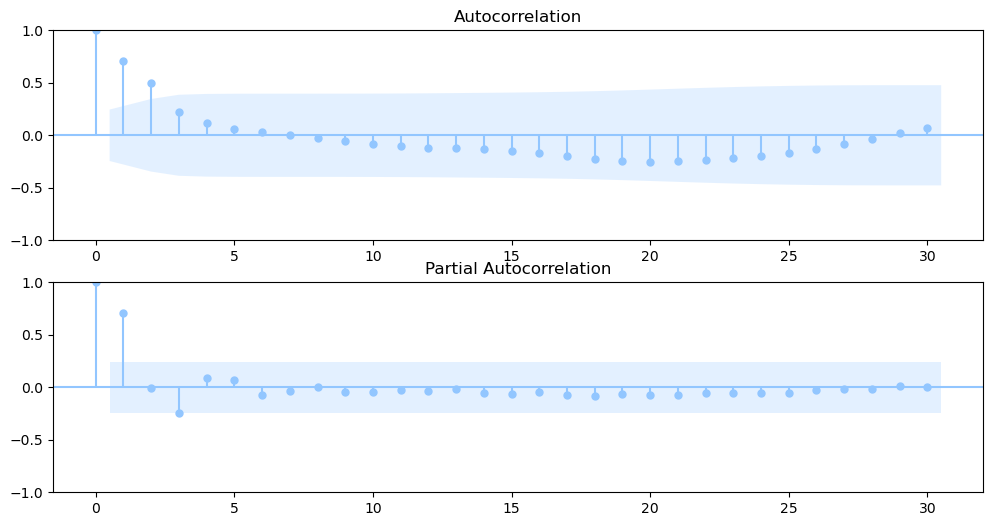

Results of Dickey-Fuller Test (H0= NO estac.):
Test Statistic -2.506588345544689
p-value 0.11387952765274156
#Lags Used 0
# obs 63
1% -3.5386953618719676
5% -2.9086446751210775
10% -2.591896782564878


In [6]:
#Dibujamos correlogramas y analizamos la estacionariedad de la serie
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(train_esp.diff(4).dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(train_esp.diff(4).dropna(), ax=ax[1], lags=30)
plt.show()
DFtest(train_esp.diff(4).dropna())

### 1.1.2. SARIMA manual

                                     SARIMAX Results                                      
Dep. Variable:                            IVE_esp   No. Observations:                   68
Model:             SARIMAX(2, 0, 1)x(0, 1, [], 4)   Log Likelihood                -156.374
Date:                            Fri, 29 Dec 2023   AIC                            322.748
Time:                                    18:23:09   BIC                            333.383
Sample:                                01-01-2004   HQIC                           326.923
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1233      1.287     -0.096      0.924      -2.645       2.398
ar.L1          0.7066     12.746   

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


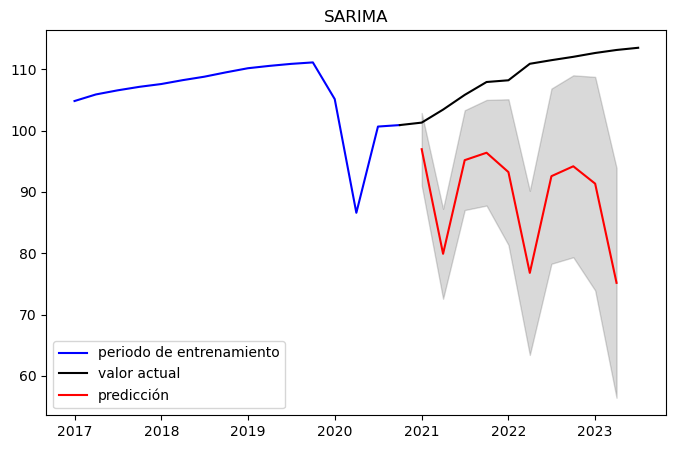

In [7]:
#Estimamos y predecimos el modelo
mod1=sm.tsa.statespace.SARIMAX(train_esp,order=(2,0,1), seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()


print(mod1.summary())
pred1=mod1.get_prediction('2021-01-01','2023-04-01')

print("                                           ")

#Hallamos el error medio:
mape(pred1.predicted_mean, test_esp)

# Dibujamos la predicción:
pred_ci1 = pred1.conf_int()

# Creando las series para su representación gráfica
pred1 = pd.Series(pred1.predicted_mean, index=test_esp.index)
lower_ci1 = pd.Series(pred_ci1["lower IVE_esp"], index=test_esp.index)
upper_ci1 = pd.Series(pred_ci1["upper IVE_esp"], index=test_esp.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
#Para que se pueda observar mejor en el informe
ax.plot(train_esp.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_esp, label="valor actual", color="black")
ax.plot(pred1, label="predicción", color='r')
ax.fill_between(lower_ci1.index,
                 lower_ci1,
                 upper_ci1,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

### 1.1.3. SARIMA Automático

In [8]:
mod2 = pm.auto_arima(train_esp, start_p=0, start_d=0, start_q=0,
                    max_p=3, max_d=1, max_q=3, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=3, max_D=1, max_Q=3,m=4, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

 ARIMA(0,1,0)(0,1,0)[4]             : AIC=325.491, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=327.396, Time=0.03 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=329.396, Time=0.04 sec
 ARIMA(0,1,0)(0,1,3)[4]             : AIC=331.270, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=327.394, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=329.377, Time=0.07 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=331.214, Time=0.07 sec
 ARIMA(0,1,0)(1,1,3)[4]             : AIC=333.052, Time=0.26 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=329.393, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=331.354, Time=0.11 sec
 ARIMA(0,1,0)(2,1,2)[4]             : AIC=333.159, Time=0.09 sec
 ARIMA(0,1,0)(2,1,3)[4]             : AIC=334.938, Time=0.25 sec
 ARIMA(0,1,0)(3,1,0)[4]             : AIC=331.242, Time=0.04 sec
 ARIMA(0,1,0)(3,1,1)[4]             : AIC=333.077, Time=0.08 sec
 ARIMA(0,1,0)(3,1,2)[4]             : AIC=334.945, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[4]  

                                     SARIMAX Results                                      
Dep. Variable:                            IVE_esp   No. Observations:                   68
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 4)   Log Likelihood                -156.023
Date:                            Fri, 29 Dec 2023   AIC                            318.047
Time:                                    18:23:34   BIC                            324.379
Sample:                                01-01-2004   HQIC                           320.528
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2309      0.763     -0.303      0.762      -1.725       1.264
ma.L1         -0.2588      0.073   

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


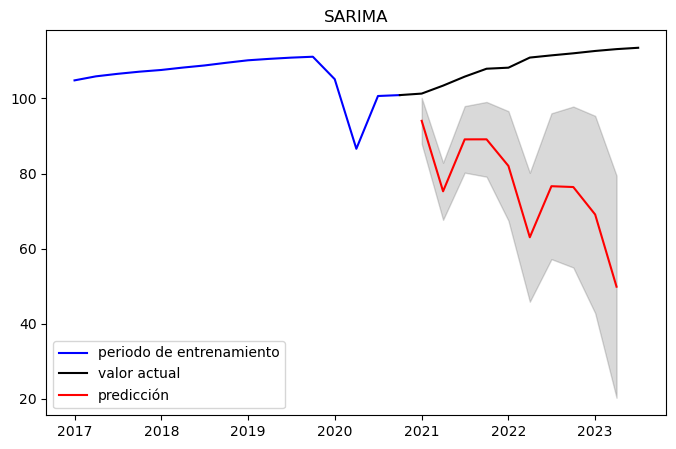

In [9]:
mod2=sm.tsa.statespace.SARIMAX(train_esp,order=(0,1,1), seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(mod2.summary())
pred2=mod2.get_prediction('2021-01-01','2023-04-01')

print("                                           ")

#Hallamos el error medio:
mape(pred2.predicted_mean, test_esp)

# Dibujamos la predicción:
pred_ci2 = pred2.conf_int()

# Creando las series para su representación gráfica
pred2 = pd.Series(pred2.predicted_mean, index=test_esp.index)
lower_ci2 = pd.Series(pred_ci2["lower IVE_esp"], index=test_esp.index)
upper_ci2 = pd.Series(pred_ci2["upper IVE_esp"], index=test_esp.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
#Para que se pueda observar mejor en el informe
ax.plot(train_esp.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_esp, label="valor actual", color="black")
ax.plot(pred2, label="predicción", color='r')
ax.fill_between(lower_ci2.index,
                 lower_ci2,
                 upper_ci2,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

### 1.1.4. Importamos variables exógenas

In [10]:
#Importamos variables mensuales
n_m=["bc","com", "exp","hip", "hot", "icn","imp", "ipd", "ipnd"]
index=pib["IVE_esp"].loc["2004":"2023"].index
exog_es={}

# Iterar sobre los nombres de los archivos Excel y crear variables separadas
for nombre in n_m:
    # Leer el archivo Excel correspondiente
    datos = f"{nombre}.xlsx"
    exog_es[nombre] = pd.read_excel(file+"/Exog PIB/"+datos)
    # Crear una variable separada para cada serie de datos
    exec(f"{nombre} = exog_es[nombre]")
    # Indexar la variable serie fecha
    eval(f"{nombre}").set_index("fecha", inplace=True)
    
m=[bc,com, exp,hip, hot, icn, imp, ipd, ipnd] 
# Iterar sobre los nombres de los archivos Excel y mostrar las primeras filas de cada serie
for variable, nombre in zip(m, n_m):
    exog_es[nombre]=variable["esp_des"].loc["2004":"2023-09-01"].resample("Q", label="right").mean().set_axis(index)

In [11]:
#Importamos variables trimestrales
ocup= pd.read_excel(file+"/Exog PIB/ocup.xlsx")
ocup.set_index("fecha", inplace=True)
ocup=ocup.loc["2004-01-01":"2023-07-01"]
ocup

,esp,ara,esp_des,ara_des
fecha,,,,
2004-01-01,17770.2,536.5,17704.033890,535.386806
2004-04-01,18018.9,543.7,17994.420389,543.319513
2004-07-01,18289.1,555.7,18193.899359,551.841691
2004-10-01,18490.8,552.0,18516.534211,556.637920
2005-01-01,18736.1,568.5,18869.817011,571.885398
...,...,...,...,...
2022-07-01,20545.7,584.0,20426.496226,584.553257
2022-10-01,20463.9,584.0,20469.229030,584.509008
2023-01-01,20452.8,591.2,20700.363706,594.199541


### 1.1.5. Selección variables exógenas

In [12]:
#Analizamos la variable que este más correlacionada:
corr_esp={}
for n in n_m:
    corr_esp[n] = np.corrcoef(exog_es[n], pib["IVE_esp"].loc["2004-01-01":"2023-07-01"])[0,1]
    print(f"Correlación entre {n}-pib en España: {corr_esp[n]}")

corr_ocupes = np.corrcoef(ocup["esp_des"], pib["IVE_esp"].loc["2004-01-01":"2023-07-01"])[0,1]
print("Correlación entre ocup-pib en España:", corr_ocupes)

Correlación entre bc-pib en España: -0.03461906972546119
Correlación entre com-pib en España: 0.42031198582066476
Correlación entre exp-pib en España: 0.6807781207917977
Correlación entre hip-pib en España: -0.1552486382471983
Correlación entre hot-pib en España: 0.6387640848090076
Correlación entre icn-pib en España: -0.0007269141747972345
Correlación entre imp-pib en España: 0.8828307876133046
Correlación entre ipd-pib en España: -0.2757193554504982
Correlación entre ipnd-pib en España: 0.4272027774626418
Correlación entre ocup-pib en España: 0.686734647080616


In [13]:
exog_es=exog_es["imp"]

### 1.1.6. SARIMAX

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                            IVE_esp   No. Observations:                   68
Model:             SARIMAX(2, 0, 1)x(0, 1, [], 4)   Log Likelihood                -134.704
Date:                            Fri, 29 Dec 2023   AIC                            281.409
Time:                                    18:23:36   BIC                            294.172
Sample:                                01-01-2004   HQIC                           286.420
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1324      0.570     -0.232      0.816      -1.250       0.986
esp_des     1.575e-06    2.1e-07   

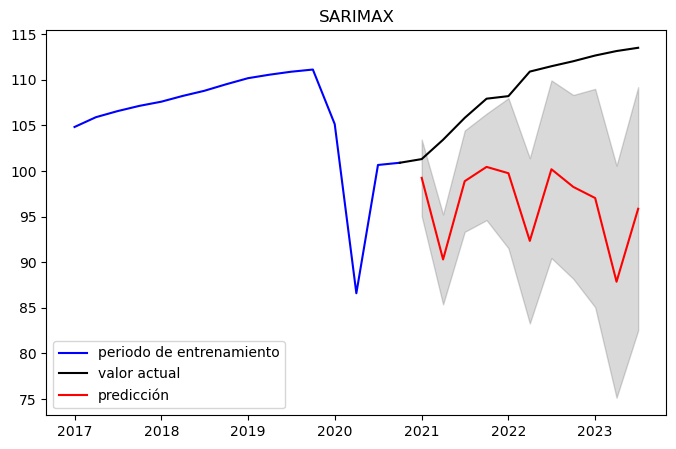

In [14]:
#Definimos trainis y test para varaible exógena:
exog_es_train=exog_es.loc[:"2020-10"]
exog_es_test=exog_es.loc["2021-01":"2023-07"]

#Estimamos y predecimos el modelo
modx1=sm.tsa.statespace.SARIMAX(train_esp,  exog=exog_es_train, order=(2,0,1),seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(modx1.summary())
predx1 = modx1.get_prediction('2021-01', '2023-07', exog=exog_es_test)

#Hallamos el error medio de la nueva predicción:
mape(predx1.predicted_mean, test_esp)

print("                                           ")

# Dibujamos la predicción:
pred_cix1 = predx1.conf_int()
pred_cix1.columns=["bajo", "alto"]

# Creando las series para su representación gráfica
bajox1=pd.Series(pred_cix1["bajo"])
altox1= pd.Series(pred_cix1["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(train_esp.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_esp, label="valor actual", color="black")
ax.plot(predx1.predicted_mean, label="predicción", color='r')
ax.fill_between(bajox1.index,
                 bajox1,
                 altox1,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMAX")
plt.show()

### 1.1.7. Estimación final

#### Predecimos importaciones

In [15]:
#Predecimos valor de las importaciones para el cuarto trimestre:
a=pm.auto_arima(exog_es, start_p=0, start_d=0, start_q=0,
                    max_p=3, max_d=1, max_q=3, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=3, max_D=1, max_Q=3,m=4, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2394.282, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=2396.263, Time=0.07 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=2398.249, Time=0.11 sec
 ARIMA(0,1,0)(0,0,3)[4] intercept   : AIC=2400.002, Time=0.12 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=2396.263, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=2398.262, Time=0.07 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(1,0,3)[4] intercept   : AIC=2401.990, Time=0.28 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=2398.248, Time=0.08 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=2400.242, Time=0.13 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(2,0,3)[4] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(3,0,0)[4] intercept   : AIC=2399.978, Time=0.13 sec
 ARIMA(0,1,0)(3,0,1)[4] intercept   : AIC=2401.965, Time=0.31 sec
 ARIMA(0,1,0)(3,0,2)[4] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[4] interc

In [16]:
#Predecimos valor:
b=sm.tsa.statespace.SARIMAX(exog_es,order=(0,1,0), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

predb=b.get_prediction("2023-10-01")

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [17]:
# Obtener las predicciones como un DataFrame con índice
b = predb.predicted_mean.to_frame(name='esp_pred')
exog_es = pd.concat([b, exog_es], axis=1)

# Asegurar que el índice sea de tipo PeriodIndex
exog_es.index = pd.PeriodIndex(exog_es.index, freq='Q')

# Convertir el índice a formato "YYYY-MM-DD"
exog_es.index = exog_es.index.to_timestamp()

# Rellenar NaN con 0
exog_es.fillna(0, inplace=True)

# Asegurarse de que 'esp_des' y 'esp_pred' sean del mismo tipo
exog_es['esp_des'] = exog_es['esp_des'].astype(float)
exog_es['esp_pred'] = exog_es['esp_pred'].astype(float)

# Unir valores
exog_es["esp"] = exog_es["esp_des"] + exog_es["esp_pred"]

# Eliminar columnas innecesarias
drop = ['esp_pred', 'esp_des']
exog_es.drop(drop, axis=1, inplace=True)

# Mostrar el DataFrame resultante
print(exog_es)


                     esp
2004-01-01  1.725169e+07
2004-04-01  1.813743e+07
2004-07-01  1.828511e+07
2004-10-01  1.852991e+07
2005-01-01  1.874672e+07
...                  ...
2022-10-01  2.488346e+07
2023-01-01  2.448754e+07
2023-04-01  2.428461e+07
2023-07-01  2.394105e+07
2023-10-01  2.402681e+07

[80 rows x 1 columns]


#### Predecimos IVE para España

D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                            IVE_esp   No. Observations:                   79
Model:             SARIMAX(2, 0, 1)x(0, 1, [], 4)   Log Likelihood                -216.616
Date:                            Fri, 29 Dec 2023   AIC                            445.232
Time:                                    18:24:05   BIC                            458.975
Sample:                                01-01-2004   HQIC                           450.709
                                     - 07-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1922      0.878      0.219      0.827      -1.529       1.914
esp         1.917e-06    1.5e-07   

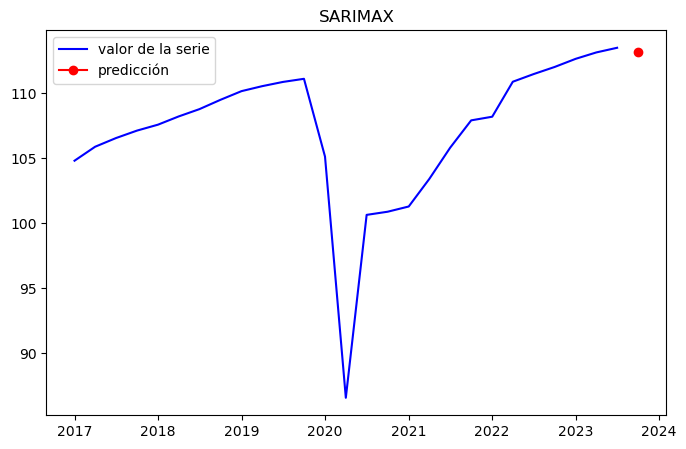

In [18]:
#Estimamos y predecimos el modelo
modxf1=sm.tsa.statespace.SARIMAX(pib["IVE_esp"].loc['2004-01-01':],  exog=exog_es.loc[:"2023-07-01"], order=(2,0,1),seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(modxf1.summary())
predxf1 = modxf1.get_prediction('2023-10', exog=exog_es.loc["2023-10-01"])

print("                                           ")


# Creando las series para su representación gráfica
bajox1=pd.Series(pred_cix1["bajo"])
altox1= pd.Series(pred_cix1["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(pib["IVE_esp"].loc["2017-01-01":], label="valor de la serie", color="blue")
ax.plot(predxf1.predicted_mean, label="predicción", marker='o', color='r')
ax.legend()
ax.set_title("SARIMAX")
plt.show()

In [19]:
# Obtener las predicciones como un DataFrame
p_esp=(pib["IVE_esp"]/pib["IVE_esp"].shift(4)-1)*100
p_esp=p_esp.loc["2017-01-01":]

pf_esp = predxf1.predicted_mean.to_frame(name='f')
pf_esp["tv"]=(pf_esp["f"]/pib["IVE_esp"].loc["2023-07-01"]-1)*100

# Mostrar el DataFrame resultante
print("El valor del IVE del PIB para España en el cuarto trimestre de 2023 es: ", pf_esp["f"])
print("La tasa de varaición del PIB para España en el cuarto trimestre de 2023 es: ", pf_esp["tv"])

El valor del IVE del PIB para España en el cuarto trimestre de 2023 es:  2023-10-01    113.19331
Freq: QS-OCT, Name: f, dtype: float64
La tasa de varaición del PIB para España en el cuarto trimestre de 2023 es:  2023-10-01   -0.275611
Freq: QS-OCT, Name: tv, dtype: float64


## 1.2. Aragón

### 1.2.1. Análisis serie

In [20]:
#División serie en partes:
train_ara=pib["IVE_ara"].loc["2004-01-01":"2020-10-01"]
test_ara=pib["IVE_ara"].loc["2020-10-01":]

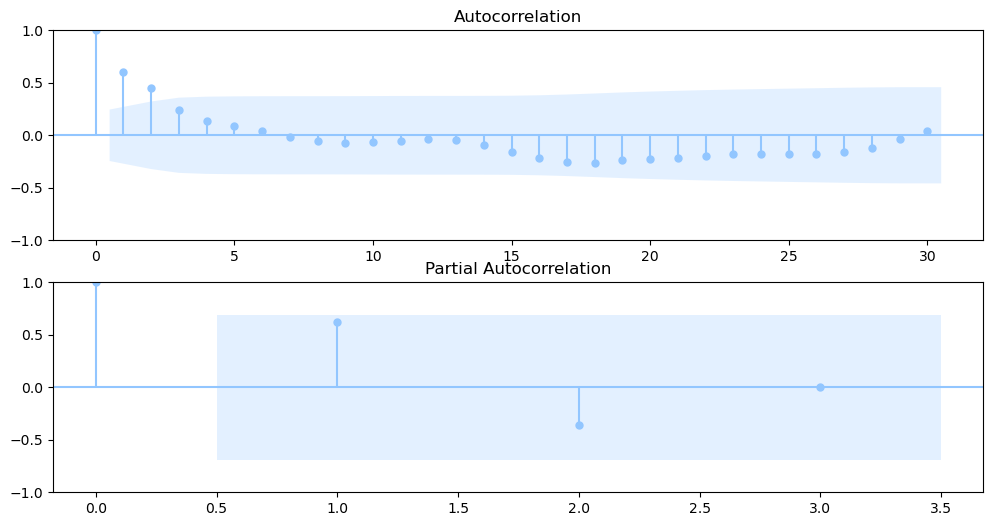

Results of Dickey-Fuller Test (H0= NO estac.):
Test Statistic -3.5534426501532836
p-value 0.006716085227461228
#Lags Used 0
# obs 63
1% -3.5386953618719676
5% -2.9086446751210775
10% -2.591896782564878


In [21]:
#Dibujamos correlogramas y analizamos la estacionariedad de la serie
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(train_ara.diff(4).dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(test_ara.diff(4).dropna(), ax=ax[1], lags=3)
plt.show()
DFtest(train_ara.diff(4).dropna())

### 1.2.2. SARIMA manual

                                     SARIMAX Results                                     
Dep. Variable:                           IVE_ara   No. Observations:                   68
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 4)   Log Likelihood                -160.583
Date:                           Fri, 29 Dec 2023   AIC                            329.166
Time:                                   18:24:06   BIC                            337.675
Sample:                               01-01-2004   HQIC                           332.507
                                    - 10-01-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0725      0.912     -0.079      0.937      -1.861       1.716
ar.L1          0.5346      0.086      6.219

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


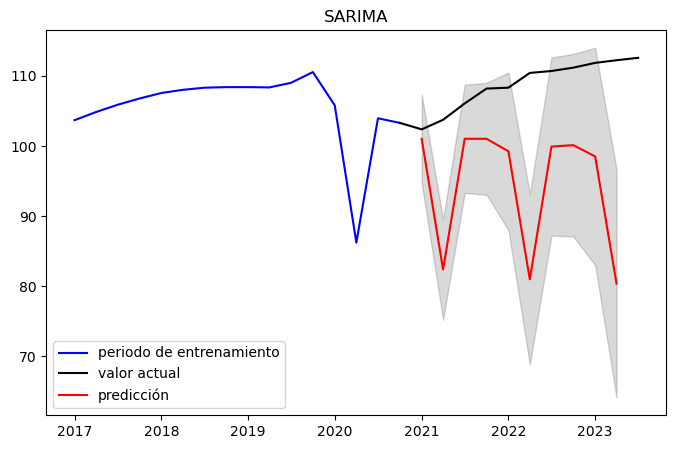

In [22]:
#Estimamos y predecimos el modelo
mod3=sm.tsa.statespace.SARIMAX(train_ara,order=(2,0,0), seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()


print(mod3.summary())
pred3=mod3.get_prediction('2021-01-01','2023-04-01')

print("                                           ")

#Hallamos el error medio:
mape(pred3.predicted_mean, test_ara)

# Dibujamos la predicción:
pred_ci3 = pred3.conf_int()

# Creando las series para su representación gráfica
pred3 = pd.Series(pred3.predicted_mean, index=test_esp.index)
lower_ci3 = pd.Series(pred_ci3["lower IVE_ara"], index=test_ara.index)
upper_ci3 = pd.Series(pred_ci3["upper IVE_ara"], index=test_ara.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
#Para que se pueda observar mejor en el informe
ax.plot(train_ara.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_ara, label="valor actual", color="black")
ax.plot(pred3, label="predicción", color='r')
ax.fill_between(lower_ci3.index,
                 lower_ci3,
                 upper_ci3,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

### 1.2.3. SARIMA Automático

In [23]:
mod4 = pm.auto_arima(train_ara, start_p=0, start_d=0, start_q=0,
                    max_p=3, max_d=1, max_q=3, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=3, max_D=1, max_Q=3,m=4, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

 ARIMA(0,1,0)(0,1,0)[4]             : AIC=341.062, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=342.542, Time=0.04 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=344.508, Time=0.06 sec
 ARIMA(0,1,0)(0,1,3)[4]             : AIC=346.470, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=342.643, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=344.519, Time=0.10 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=346.481, Time=0.18 sec
 ARIMA(0,1,0)(1,1,3)[4]             : AIC=348.462, Time=0.37 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=344.462, Time=0.08 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=346.447, Time=0.17 sec
 ARIMA(0,1,0)(2,1,2)[4]             : AIC=348.443, Time=0.28 sec
 ARIMA(0,1,0)(2,1,3)[4]             : AIC=350.455, Time=0.39 sec
 ARIMA(0,1,0)(3,1,0)[4]             : AIC=346.444, Time=0.12 sec
 ARIMA(0,1,0)(3,1,1)[4]             : AIC=348.444, Time=0.23 sec
 ARIMA(0,1,0)(3,1,2)[4]             : AIC=350.443, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[4]  

                                     SARIMAX Results                                      
Dep. Variable:                            IVE_ara   No. Observations:                   68
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 4)   Log Likelihood                -160.366
Date:                            Fri, 29 Dec 2023   AIC                            326.733
Time:                                    18:24:30   BIC                            333.065
Sample:                                01-01-2004   HQIC                           329.215
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1772      0.466     -0.380      0.704      -1.091       0.737
ma.L1         -0.4474      0.075   

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


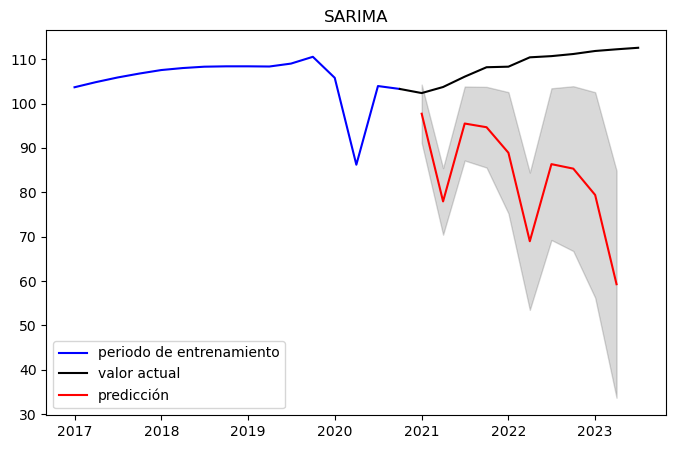

In [24]:
#Estimamos y predecimos el modelo
mod4=sm.tsa.statespace.SARIMAX(train_ara,order=(0,1,1), seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()


print(mod4.summary())
pred4=mod4.get_prediction('2021-01-01','2023-04-01')

print("                                           ")

#Hallamos el error medio:
mape(pred4.predicted_mean, test_ara)

# Dibujamos la predicción:
pred_ci4 = pred4.conf_int()

# Creando las series para su representación gráfica
pred4 = pd.Series(pred4.predicted_mean, index=test_esp.index)
lower_ci4 = pd.Series(pred_ci4["lower IVE_ara"], index=test_ara.index)
upper_ci4 = pd.Series(pred_ci4["upper IVE_ara"], index=test_ara.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
#Para que se pueda observar mejor en el informe
ax.plot(train_ara.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_ara, label="valor actual", color="black")
ax.plot(pred4, label="predicción", color='r')
ax.fill_between(lower_ci4.index,
                 lower_ci4,
                 upper_ci4,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

### 1.2.4. Importamos variables exógenas

In [25]:
#Importamos variables mensuales
n_m=["bc","com", "exp","hip", "hot", "icn","imp", "ipd", "ipnd"]
index=pib["IVE_ara"].loc["2008":"2023"].index
exog_ar={}

# Iterar sobre los nombres de los archivos Excel y crear variables separadas
for nombre in n_m:
    # Leer el archivo Excel correspondiente
    datos = f"{nombre}.xlsx"
    exog_ar[nombre] = pd.read_excel(file+"/Exog PIB/"+datos)
    # Crear una variable separada para cada serie de datos
    exec(f"{nombre} = exog_ar[nombre]")
    # Indexar la variable serie fecha
    eval(f"{nombre}").set_index("fecha", inplace=True)
    
m=[bc,com, exp,hip, hot, icn, imp, ipd, ipnd] 
# Iterar sobre los nombres de los archivos Excel y mostrar las primeras filas de cada serie
for variable, nombre in zip(m, n_m):
    exog_ar[nombre]=variable["ara_des"].loc["2008":"2023-09-01"].resample("Q", label="right").mean().set_axis(index)

In [26]:
#Importamos variables trimestrales
ocup=pd.read_excel(file+"/Exog PIB/ocup.xlsx")
ocup.set_index("fecha", inplace=True)
ocup=ocup.loc["2008-01-01":"2023-07-01"]
ocup

,esp,ara,esp_des,ara_des
fecha,,,,
2008-01-01,20620.0,626.9,20584.277793,630.404108
2008-04-01,20646.9,629.2,20630.121495,629.221482
2008-07-01,20556.4,632.4,20434.910098,621.934333
2008-10-01,20055.3,614.1,20006.450049,612.206028
2009-01-01,19284.4,585.0,19524.453445,595.752945
...,...,...,...,...
2022-07-01,20545.7,584.0,20426.496226,584.553257
2022-10-01,20463.9,584.0,20469.229030,584.509008
2023-01-01,20452.8,591.2,20700.363706,594.199541


### 1.1.5. Selección variables exógenas

In [27]:
#Analizamos la variable que este más correlacionada:
corr_ara={}
for n in n_m:
    corr_ara[n] = np.corrcoef(exog_ar[n], pib["IVE_ara"].loc["2008-01-01":"2023-07-01"])[0,1]
    print(f"Correlación entre {n}-pib en Aragón: {corr_ara[n]}")

corr_ocupar = np.corrcoef(ocup["ara_des"], pib["IVE_ara"].loc["2008-01-01":"2023-07-01"])[0,1]
print("Correlación entre ocup-pib en Aragón:", corr_ocupar)

Correlación entre bc-pib en Aragón: -0.2762774017154862
Correlación entre com-pib en Aragón: 0.5103942279627072
Correlación entre exp-pib en Aragón: 0.673104400917515
Correlación entre hip-pib en Aragón: 0.20515668596237718
Correlación entre hot-pib en Aragón: 0.6696098780938107
Correlación entre icn-pib en Aragón: 0.3104496166467405
Correlación entre imp-pib en Aragón: 0.7423454938755601
Correlación entre ipd-pib en Aragón: -0.17575180898621862
Correlación entre ipnd-pib en Aragón: 0.6767610802347325
Correlación entre ocup-pib en Aragón: 0.7149116463833631


In [28]:
exog_ar=exog_ar["imp"]
exog_ar

fecha
2008-01-01    7.867666e+05
2008-04-01    7.216648e+05
2008-07-01    6.337345e+05
2008-10-01    5.361382e+05
2009-01-01    4.686837e+05
                  ...     
2022-07-01    1.278807e+06
2022-10-01    1.326112e+06
2023-01-01    1.523881e+06
2023-04-01    1.528139e+06
2023-07-01    1.582226e+06
Name: ara_des, Length: 63, dtype: float64

### 1.2.6. SARIMAX

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                           IVE_ara   No. Observations:                   52
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 4)   Log Likelihood                -100.246
Date:                           Fri, 29 Dec 2023   AIC                            210.492
Time:                                   18:24:32   BIC                            219.635
Sample:                               01-01-2008   HQIC                           213.917
                                    - 10-01-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4603      0.449     -1.024      0.306      -1.341       0.420
ara_des     2.827e-05   2.89e-06      9.799

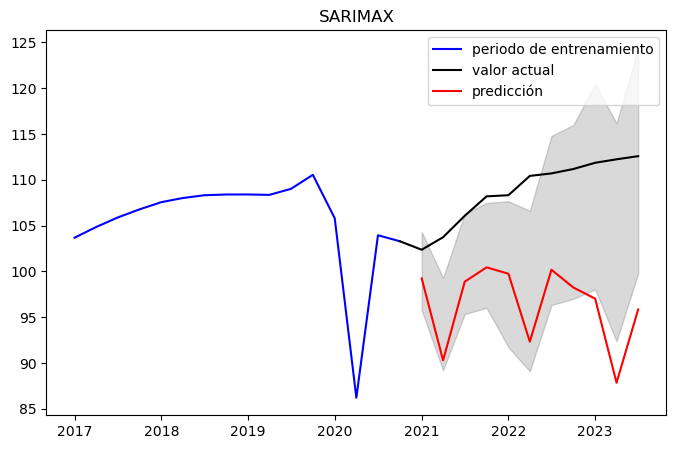

In [29]:
#Definimos trainis y test para varaible exógena:
exog_ar_train=exog_ar.loc[:"2020-10"]
exog_ar_test=exog_ar.loc["2021-01":"2023-07"]

#Estimamos y predecimos el modelo
modx2=sm.tsa.statespace.SARIMAX(train_ara.loc["2008-01":],  exog=exog_ar_train, order=(2,0,0),seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(modx2.summary())
predx2 = modx2.get_prediction('2021-01', '2023-07', exog=exog_ar_test)

#Hallamos el error medio de la nueva predicción:
mape(predx2.predicted_mean, test_ara)

print("                                           ")

# Dibujamos la predicción:
pred_cix2 = predx2.conf_int()
pred_cix2.columns=["bajo", "alto"]

# Creando las series para su representación gráfica
bajox2=pd.Series(pred_cix2["bajo"])
altox2= pd.Series(pred_cix2["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(train_ara.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_ara, label="valor actual", color="black")
ax.plot(predx1.predicted_mean, label="predicción", color='r')
ax.fill_between(bajox2.index,
                 bajox2,
                 altox2,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMAX")
plt.show()

### 1.2.7. Estimación final

#### Predecimos importaciones

In [30]:
#Predecimos valor de las importaciones para el cuarto trimestre:
c=pm.auto_arima(exog_ar, start_p=0, start_d=0, start_q=0,
                    max_p=3, max_d=1, max_q=3, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=3, max_D=1, max_Q=3,m=4, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1600.319, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=1602.280, Time=0.07 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=1602.502, Time=0.13 sec
 ARIMA(0,1,0)(0,0,3)[4] intercept   : AIC=1604.161, Time=0.16 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=1602.289, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=1602.887, Time=0.18 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=1603.824, Time=0.28 sec
 ARIMA(0,1,0)(1,0,3)[4] intercept   : AIC=1605.823, Time=0.30 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=1602.744, Time=0.07 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=1603.961, Time=0.19 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=1605.490, Time=0.23 sec
 ARIMA(0,1,0)(2,0,3)[4] intercept   : AIC=1607.458, Time=0.36 sec
 ARIMA(0,1,0)(3,0,0)[4] intercept   : AIC=1604.452, Time=0.11 sec
 ARIMA(0,1,0)(3,0,1)[4] intercept   : AIC=1605.949, Time=0.34 sec
 ARIMA(0,1,0)(3,0,2)[4] intercept   : AIC=1607.452, Time=0.44 sec
 ARIMA(0,1

In [31]:
#Predecimos valor:
d=sm.tsa.statespace.SARIMAX(exog_ar,order=(1,1,0), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

predd=d.get_prediction("2023-10-01")

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [32]:
# Obtener las predicciones como un DataFrame con índice
d = predd.predicted_mean.to_frame(name='ara_pred')
exog_ar = pd.concat([d, exog_ar], axis=1)

# Asegurar que el índice sea de tipo PeriodIndex
exog_ar.index = pd.PeriodIndex(exog_ar.index, freq='Q')

# Convertir el índice a formato "YYYY-MM-DD"
exog_ar.index = exog_ar.index.to_timestamp()

# Rellenar NaN con 0
exog_ar.fillna(0, inplace=True)

# Asegurarse de que 'esp_des' y 'esp_pred' sean del mismo tipo
exog_ar['ara_des'] = exog_ar['ara_des'].astype(float)
exog_ar['ara_pred'] = exog_ar['ara_pred'].astype(float)

# Unir valores
exog_ar["ara"] = exog_ar["ara_des"] + exog_ar["ara_pred"]

# Eliminar columnas innecesarias
drop = ['ara_pred', 'ara_des']
exog_ar.drop(drop, axis=1, inplace=True)

# Mostrar el DataFrame resultante
print(exog_ar)

                     ara
2008-01-01  7.867666e+05
2008-04-01  7.216648e+05
2008-07-01  6.337345e+05
2008-10-01  5.361382e+05
2009-01-01  4.686837e+05
...                  ...
2022-10-01  1.326112e+06
2023-01-01  1.523881e+06
2023-04-01  1.528139e+06
2023-07-01  1.582226e+06
2023-10-01  1.583488e+06

[64 rows x 1 columns]


#### Predecimos IVE para Aragón

                                     SARIMAX Results                                     
Dep. Variable:                           IVE_ara   No. Observations:                   63
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 4)   Log Likelihood                -131.617
Date:                           Fri, 29 Dec 2023   AIC                            273.233
Time:                                   18:24:58   BIC                            283.448
Sample:                               01-01-2008   HQIC                           277.203
                                    - 07-01-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4330      0.502     -0.862      0.389      -1.418       0.552
ara         2.726e-05   2.54e-06     10.750

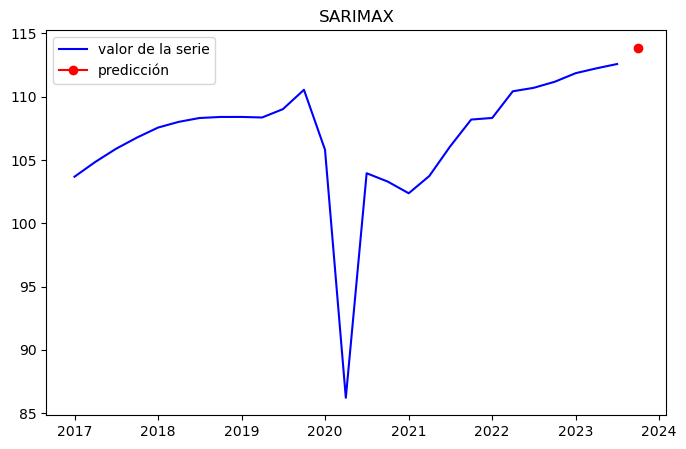

In [33]:
#Estimamos y predecimos el modelo
modxf2=sm.tsa.statespace.SARIMAX(pib["IVE_ara"].loc['2008-01-01':],  exog=exog_ar.loc[:"2023-07-01"], order=(2,0,0),seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(modxf2.summary())
predxf2 = modxf2.get_prediction('2023-10', exog=exog_ar.loc["2023-10-01"])

print("                                           ")


# Creando las series para su representación gráfica
bajox2=pd.Series(pred_cix2["bajo"])
altox2= pd.Series(pred_cix2["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(pib["IVE_ara"].loc["2017-01-01":], label="valor de la serie", color="blue")
ax.plot(predxf2.predicted_mean, label="predicción", marker='o', color='r')
ax.legend()
ax.set_title("SARIMAX")
plt.show()

In [34]:
# Obtener las predicciones como un DataFrame
p_ara=(pib["IVE_ara"]/pib["IVE_ara"].shift(4)-1)*100
p_ara=p_ara.loc["2017-01-01":]

pf_ara = predxf2.predicted_mean.to_frame(name='f')
pf_ara["tv"]=(pf_ara["f"]/pib["IVE_ara"].loc["2023-07-01"]-1)*100

# Mostrar el DataFrame resultante
print("El valor del IVE del PIB para Aragón en el cuarto trimestre de 2023 es: ", pf_ara["f"])
print("La tasa de varaición del PIB para Aragón en el cuarto trimestre de 2023 es: ", pf_ara["tv"])

El valor del IVE del PIB para Aragón en el cuarto trimestre de 2023 es:  2023-10-01    113.860385
Freq: QS-OCT, Name: f, dtype: float64
La tasa de varaición del PIB para Aragón en el cuarto trimestre de 2023 es:  2023-10-01    1.139296
Freq: QS-OCT, Name: tv, dtype: float64


# 2. Tasa de paro

In [35]:
tp=pd.read_excel("tp.xlsx")
tp.set_index("fecha", inplace=True)
tp

,hom_esp,hom_ara,muj_esp,muj_ara,esp,ara,esp_des,ara_des,esp_dif,ara_dif,esp_dif_des,ara_dif_des
fecha,,,,,,,,,,,,
2002-01-01,8.36,3.57,16.35,8.48,12.355,6.025,11.977593,5.460956,7.99,4.91,7.971805,5.502626
2002-04-01,7.86,3.50,16.04,9.72,11.950,6.610,12.146584,6.403222,8.18,6.22,8.229338,5.909605
2002-07-01,8.33,3.40,16.20,9.09,12.265,6.245,12.373157,7.033866,7.87,5.69,7.968839,5.786198
2002-10-01,8.65,4.09,16.00,10.49,12.325,7.290,12.384838,7.536091,7.35,6.40,7.276587,6.164730
2003-01-01,8.76,5.33,16.73,10.60,12.745,7.965,12.295736,7.101180,7.97,5.27,7.903937,5.478339
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,10.74,7.18,14.84,11.24,12.790,9.210,12.930551,9.521331,4.10,4.06,3.880691,4.578920
2022-10-01,11.32,7.48,14.61,11.60,12.965,9.540,13.049251,9.391341,3.29,4.12,3.420575,4.309356
2023-01-01,11.57,6.68,15.13,11.38,13.350,9.030,12.730224,8.724935,3.56,4.70,3.417090,4.676964


## 2.1. España

### 2.1.1. Análisis serie

In [36]:
#División serie en partes:
train_esp=tp["esp_des"].loc[:"2020-10-01"].astype(float)
test_esp=tp["esp_des"].loc["2021-01-01":].astype(float)

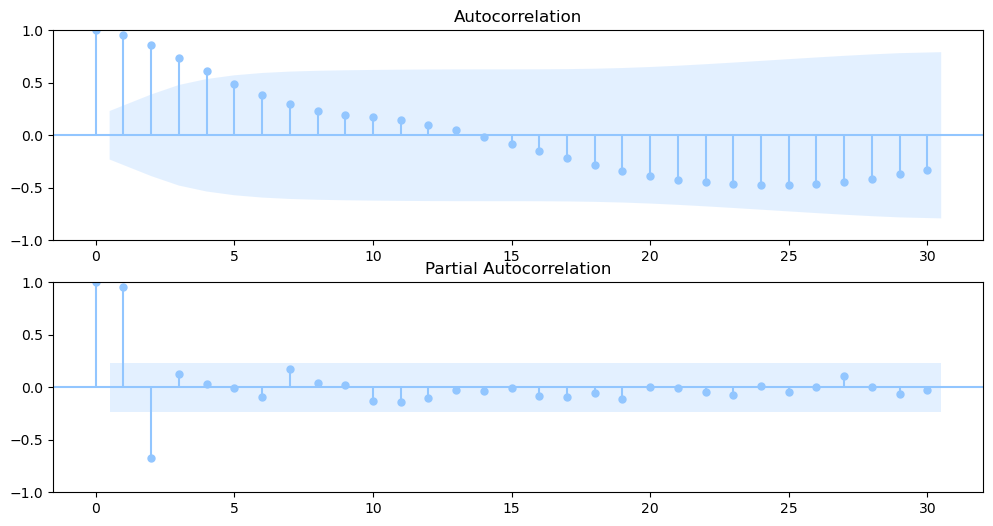

Results of Dickey-Fuller Test (H0= NO estac.):
Test Statistic -2.0413771492180723
p-value 0.2687303693406906
#Lags Used 9
# obs 62
1% -3.540522678829176
5% -2.9094272025108254
10% -2.5923136524453696


In [37]:
#Dibujamos correlogramas y analizamos la estacionariedad de la serie
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(train_esp.diff(4).dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(train_esp.diff(4).dropna(), ax=ax[1], lags=30)
plt.show()
DFtest(train_esp.diff(4).dropna())

### 2.1.2. SARIMA manual

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            esp_des   No. Observations:                   76
Model:             SARIMAX(4, 0, 2)x(0, 1, [], 4)   Log Likelihood                 -41.394
Date:                            Fri, 29 Dec 2023   AIC                             98.788
Time:                                    18:25:00   BIC                            116.544
Sample:                                01-01-2002   HQIC                           105.824
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0118      0.067      0.177      0.859      -0.119       0.143
ar.L1          2.1571      2.737   

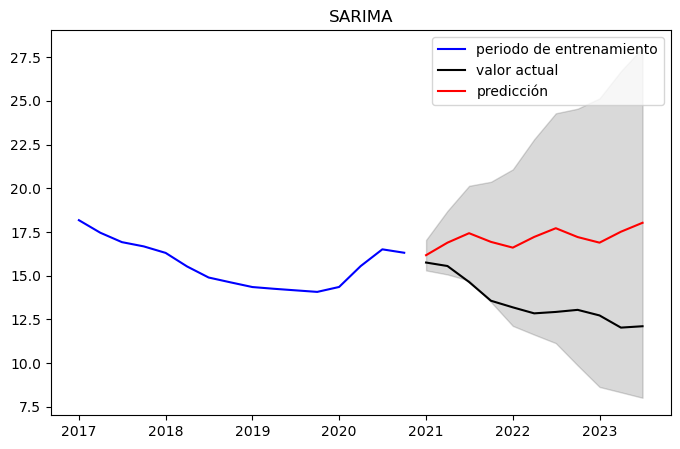

In [38]:
#Estimamos y predecimos el modelo
mod5=sm.tsa.statespace.SARIMAX(train_esp,order=(4,0,2), seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()


print(mod5.summary())
pred5=mod5.get_prediction('2021-01-01','2023-07-01')

print("                                           ")

#Hallamos el error medio:
mape(pred5.predicted_mean, test_esp)

# Dibujamos la predicción:
pred_ci5 = pred5.conf_int()

# Creando las series para su representación gráfica
pred5 = pd.Series(pred5.predicted_mean, index=test_esp.index)
lower_ci5 = pd.Series(pred_ci5["lower esp_des"], index=test_esp.index)
upper_ci5 = pd.Series(pred_ci5["upper esp_des"], index=test_esp.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
#Para que se pueda observar mejor en el informe
ax.plot(train_esp.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_esp, label="valor actual", color="black")
ax.plot(pred5, label="predicción", color='r')
ax.fill_between(lower_ci5.index,
                 lower_ci5,
                 upper_ci5,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

### 2.1.3. SARIMA Automático

In [39]:
mod6 = pm.auto_arima(train_esp, start_p=0, start_d=0, start_q=0,
                    max_p=3, max_d=1, max_q=3, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=3, max_D=1, max_Q=3,m=4, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=155.761, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=133.201, Time=0.14 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=135.175, Time=0.14 sec
 ARIMA(0,1,0)(0,0,3)[4] intercept   : AIC=136.423, Time=0.21 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=138.553, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=135.168, Time=0.16 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=137.071, Time=0.37 sec
 ARIMA(0,1,0)(1,0,3)[4] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=138.319, Time=0.14 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=136.749, Time=0.29 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=138.698, Time=0.48 sec
 ARIMA(0,1,0)(2,0,3)[4] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(3,0,0)[4] intercept   : AIC=139.357, Time=0.21 sec
 ARIMA(0,1,0)(3,0,1)[4] intercept   : AIC=138.477, Time=0.36 sec
 ARIMA(0,1,0)(3,0,2)[4] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   :

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                                esp_des   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                 -19.081
Date:                                Fri, 29 Dec 2023   AIC                             50.161
Time:                                        18:26:04   BIC                             63.207
Sample:                                    01-01-2002   HQIC                            55.309
                                         - 10-01-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.027e-05      0.020      0.002      0.999      -0.039       0.039
ar.

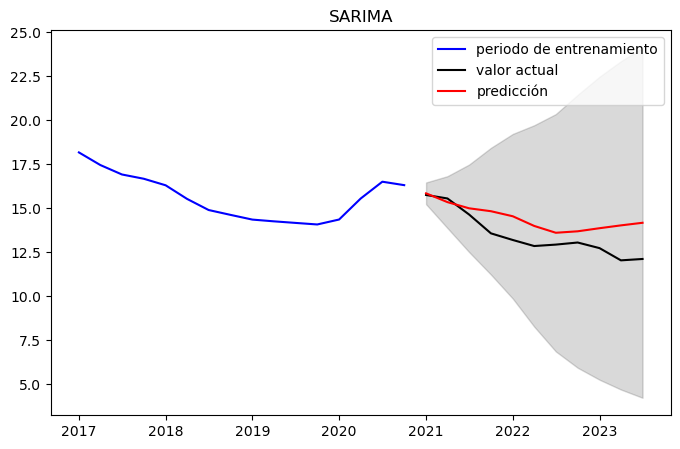

In [40]:
mod6=sm.tsa.statespace.SARIMAX(train_esp,order=(1,1,1), seasonal_order=(0,0,2,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()
print(mod6.summary())
pred6=mod6.get_prediction('2021-01-01','2023-07-01')

print("                                           ")

#Hallamos el error medio:
mape(pred6.predicted_mean, test_esp)

# Dibujamos la predicción:
pred_ci6 = pred6.conf_int()

# Creando las series para su representación gráfica
pred6 = pd.Series(pred6.predicted_mean, index=test_esp.index)
lower_ci6 = pd.Series(pred_ci6["lower esp_des"], index=test_esp.index)
upper_ci6 = pd.Series(pred_ci6["upper esp_des"], index=test_esp.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
#Para que se pueda observar mejor en el informe
ax.plot(train_esp.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_esp, label="valor actual", color="black")
ax.plot(pred6, label="predicción", color='r')
ax.fill_between(lower_ci6.index,
                 lower_ci6,
                 upper_ci6,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

### 2.1.4. Importamos variables exógenas

In [41]:
#Importamos variables 
afil=pd.read_excel(file+"/Exog tp/afil.xlsx")
afil.set_index("fecha", inplace=True)
afil=afil["esp_des"]

par=pd.read_excel(file+"/Exog tp/par.xlsx")
par.set_index("fecha", inplace=True)
par=par["esp_des"].loc["2012-01":"2023-07"]

ta=pd.read_excel(file+"/Exog tp/ta.xlsx")
ta.set_index("fecha", inplace=True)
ta=ta["esp_des"].loc["2012-01":"2023-07"]

te=pd.read_excel(file+"/Exog tp/te.xlsx")
te.set_index("fecha", inplace=True)
te=te["esp_des"].loc["2012-01":"2023-07"]

tt=pd.read_excel(file+"/Exog tp/tt.xlsx")
tt.set_index("fecha", inplace=True)
tt=tt["esp_des"].loc["2012-01":"2023-07"]

In [42]:
#Analizamos la variable que este más correlacionada:
n_var=["afil", "par", "ta", "te", "tt"]
var=[afil, par, ta, te, tt]
exog_es={}
corr_esp={}

for x,n in zip(var, n_var):
    exog_es[n]=x
    corr_esp[n] = np.corrcoef(exog_es[n], tp["esp_des"].loc["2012-01-01":"2023-07-01"])[0,1]
    print(f"Correlación entre {n}-tp en España: {corr_esp[n]}")

Correlación entre afil-tp en España: -0.9741225383436922
Correlación entre par-tp en España: 0.9983316536291605
Correlación entre ta-tp en España: 0.7135782334603351
Correlación entre te-tp en España: -0.9788696503650735
Correlación entre tt-tp en España: 0.10143555298017704


In [43]:
par=pd.read_excel(file+"/Exog tp/par.xlsx")
par.set_index("fecha", inplace=True)
par=par["esp_des"].loc["2011-01":"2023-07"]
exog_es=(par/par.shift(4)-1)*100
exog_es=exog_es.dropna()
exog_es.columns=["esp_des"]

### 2.1.6. SARIMAX

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                                esp_des   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                  -0.390
Date:                                Fri, 29 Dec 2023   AIC                             14.780
Time:                                        18:26:06   BIC                             23.313
Sample:                                    01-01-2012   HQIC                            17.147
                                         - 10-01-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2665      0.342     -0.778      0.437      -0.938       0.405
esp

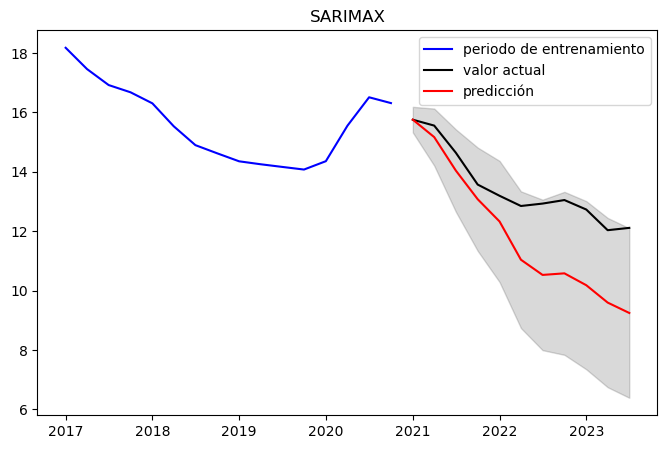

In [44]:
#Definimos trainis y test para varaible exógena:
exog_es_train=exog_es.loc[:"2020-10"]
exog_es_test=exog_es.loc["2021-01":"2023-07"]

#Estimamos y predecimos el modelo
modx3=sm.tsa.statespace.SARIMAX(train_esp.loc["2012-01":],  exog=exog_es_train, order=(1,1,1),seasonal_order=(0,0,2,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(modx3.summary())
predx3 = modx3.get_prediction('2021-01', '2023-07', exog=exog_es_test)

#Hallamos el error medio de la nueva predicción:
mape(predx3.predicted_mean, test_esp)

print("                                           ")

# Dibujamos la predicción:
pred_cix3 = predx3.conf_int()
pred_cix3.columns=["bajo", "alto"]

# Creando las series para su representación gráfica
bajox3=pd.Series(pred_cix3["bajo"])
altox3= pd.Series(pred_cix3["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(train_esp.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_esp, label="valor actual", color="black")
ax.plot(predx3.predicted_mean, label="predicción", color='r')
ax.fill_between(bajox3.index,
                 bajox3,
                 altox3,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMAX")
plt.show()

### 2.1.7. Estimación final

#### Predecimos parados

In [45]:
#Predecimos valor de las importaciones para el cuarto trimestre:
e=pm.auto_arima(exog_es, start_p=0, start_d=0, start_q=0,
                    max_p=3, max_d=1, max_q=3, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=3, max_D=1, max_Q=3,m=4, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=258.984, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,3)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=254.678, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(1,0,3)[4] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=254.619, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(2,0,3)[4] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(3,0,0)[4] intercept   : AIC=256.597, Time=0.13 sec
 ARIMA(0,1,0)(3,0,1)[4] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(3,0,2)[4] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0

In [46]:
#Predecimos valor:
f=sm.tsa.statespace.SARIMAX(exog_es,order=(0,1,1),seasonal_order=(2,0,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

predf=f.get_prediction("2023-10-01")

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [47]:
# Obtener las predicciones como un DataFrame con índice
f = predf.predicted_mean.to_frame(name='esp_pred')
exog_es = pd.concat([f, exog_es], axis=1)

# Asegurar que el índice sea de tipo PeriodIndex
exog_es.index = pd.PeriodIndex(exog_es.index, freq='Q')

# Convertir el índice a formato "YYYY-MM-DD"
exog_es.index = exog_es.index.to_timestamp()

# Rellenar NaN con 0
exog_es.fillna(0, inplace=True)

# Asegurarse de que 'esp_des' y 'esp_pred' sean del mismo tipo
exog_es['esp_des'] = exog_es['esp_des'].astype(float)
exog_es['esp_pred'] = exog_es['esp_pred'].astype(float)

# Unir valores
exog_es["esp"] = exog_es["esp_des"] + exog_es["esp_pred"]

# Eliminar columnas innecesarias
drop = ['esp_pred', 'esp_des']
exog_es.drop(drop, axis=1, inplace=True)

# Mostrar el DataFrame resultante
print(exog_es)

                  esp
2012-01-01  16.307445
2012-04-01  18.424467
2012-07-01  15.765082
2012-10-01  13.623371
2013-01-01  10.453015
2013-04-01   5.545503
2013-07-01   2.093669
2013-10-01  -1.434778
2014-01-01  -5.606415
2014-04-01  -6.988083
2014-07-01  -8.553721
2014-10-01  -8.774094
2015-01-01  -7.638853
2015-04-01  -8.419801
2015-07-01 -11.242130
2015-10-01 -12.351708
2016-01-01 -12.431343
2016-04-01 -11.080881
2016-07-01  -9.867769
2016-10-01 -10.439248
2017-01-01 -12.058894
2017-04-01 -14.285072
2017-07-01 -13.579390
2017-10-01 -11.489733
2018-01-01 -10.392576
2018-04-01 -10.609279
2018-07-01 -11.578035
2018-10-01 -12.042549
2019-01-01 -11.860367
2019-04-01  -7.115240
2019-07-01  -3.670036
2019-10-01  -3.418565
2020-01-01  -0.190514
2020-04-01   4.541835
2020-07-01  13.728177
2020-10-01  15.388425
2021-01-01  10.679356
2021-04-01   5.520590
2021-07-01  -8.173859
2021-10-01 -15.520634
2022-01-01 -14.767840
2022-04-01 -16.960834
2022-07-01 -11.553495
2022-10-01  -2.532167
2023-01-01

#### Predecimos TP para España

                                       SARIMAX Results                                        
Dep. Variable:                                esp_des   No. Observations:                   47
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                  -0.943
Date:                                Fri, 29 Dec 2023   AIC                             15.886
Time:                                        18:26:52   BIC                             26.970
Sample:                                    01-01-2012   HQIC                            19.754
                                         - 07-01-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4158      0.189     -2.197      0.028      -0.787      -0.045
esp

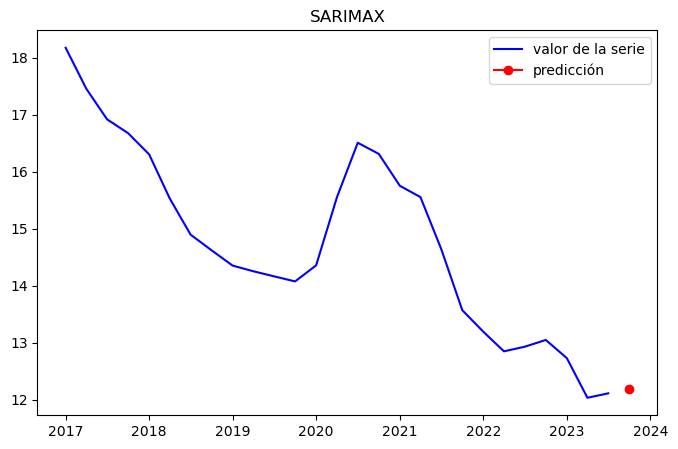

In [48]:
#Estimamos y predecimos el modelo
modxf3=sm.tsa.statespace.SARIMAX(tp["esp_des"].loc['2012-01-01':],  exog=exog_es.loc[:"2023-07-01"], order=(1,1,1),seasonal_order=(0,0,2,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(modxf3.summary())
predxf3 = modxf3.get_prediction('2023-10', exog=exog_es.loc["2023-10-01"])

print("                                           ")


# Creando las series para su representación gráfica
bajox3=pd.Series(pred_cix3["bajo"])
altox3= pd.Series(pred_cix3["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(tp["esp_des"].loc["2017-01-01":], label="valor de la serie", color="blue")
ax.plot(predxf3.predicted_mean, label="predicción", marker='o', color='r')
ax.legend()
ax.set_title("SARIMAX")
plt.show()

In [49]:
# Obtener las predicciones como un DataFrame
tp_esp=tp["esp_des"].loc["2017-01-01":]

tpf_esp = predxf3.predicted_mean.to_frame(name='f')

# Mostrar el DataFrame resultante
print("El valor de la tasa de paro para España en el cuarto trimestre de 2023 es: ", tpf_esp["f"])

El valor de la tasa de paro para España en el cuarto trimestre de 2023 es:  2023-10-01    12.187359
Freq: QS-OCT, Name: f, dtype: float64


## 2.2. Aragón

### 2.2.1. Análisis serie

In [50]:
#División serie en partes:
train_ara=tp["ara_des"].loc[:"2020-10-01"].astype(float)
test_ara=tp["ara_des"].loc["2021-01-01":].astype(float)

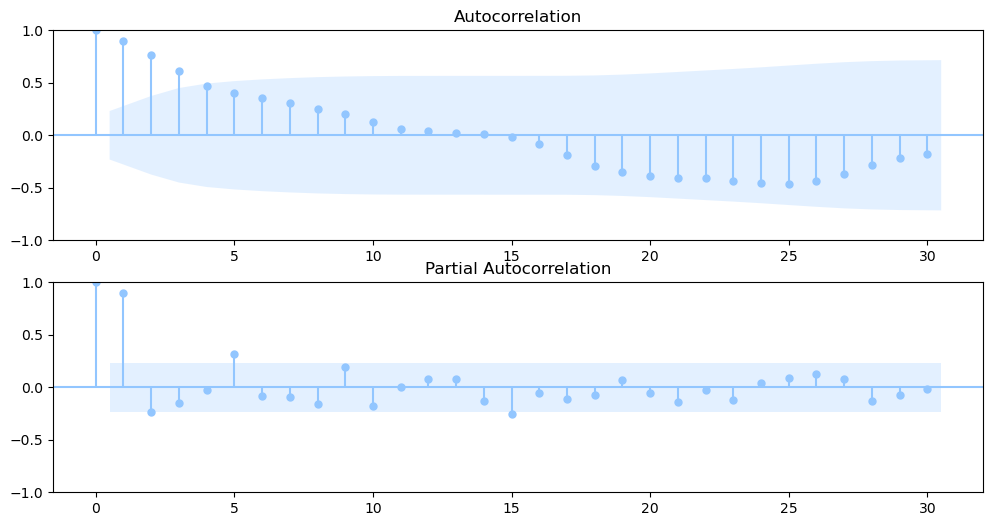

Results of Dickey-Fuller Test (H0= NO estac.):
Test Statistic -1.8343743858824315
p-value 0.363534188650544
#Lags Used 9
# obs 62
1% -3.540522678829176
5% -2.9094272025108254
10% -2.5923136524453696


In [51]:
#Dibujamos correlogramas y analizamos la estacionariedad de la serie
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(train_ara.diff(4).dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(train_ara.diff(4).dropna(), ax=ax[1], lags=30)
plt.show()
DFtest(train_ara.diff(4).dropna())

### 2.2.2. SARIMA manual

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                            ara_des   No. Observations:                   76
Model:             SARIMAX(3, 0, 2)x(0, 1, [], 4)   Log Likelihood                 -92.378
Date:                            Fri, 29 Dec 2023   AIC                            198.755
Time:                                    18:26:54   BIC                            214.394
Sample:                                01-01-2002   HQIC                           204.959
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0502      0.110      0.454      0.650      -0.166       0.267
ar.L1          1.2741      1.220   

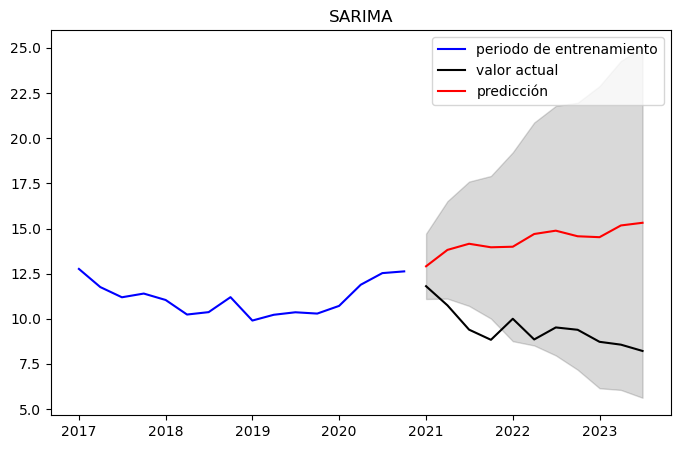

In [52]:
#Estimamos y predecimos el modelo
mod7=sm.tsa.statespace.SARIMAX(train_ara,order=(3,0,2), seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()


print(mod7.summary())
pred7=mod7.get_prediction('2021-01-01','2023-07-01')

print("                                           ")

#Hallamos el error medio:
mape(pred7.predicted_mean, test_ara)

# Dibujamos la predicción:
pred_ci7 = pred7.conf_int()

# Creando las series para su representación gráfica
pred7 = pd.Series(pred7.predicted_mean, index=test_esp.index)
lower_ci7 = pd.Series(pred_ci7["lower ara_des"], index=test_esp.index)
upper_ci7 = pd.Series(pred_ci7["upper ara_des"], index=test_esp.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
#Para que se pueda observar mejor en el informe
ax.plot(train_ara.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_ara, label="valor actual", color="black")
ax.plot(pred7, label="predicción", color='r')
ax.fill_between(lower_ci7.index,
                 lower_ci7,
                 upper_ci7,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

### 2.2.3. SARIMA Automático

In [53]:
mod8 = pm.auto_arima(train_ara, start_p=0, start_d=0, start_q=0,
                    max_p=3, max_d=1, max_q=3, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=3, max_D=1, max_Q=3,m=4, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=178.085, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=177.471, Time=0.10 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=179.411, Time=0.10 sec
 ARIMA(0,1,0)(0,0,3)[4] intercept   : AIC=181.266, Time=0.19 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=177.429, Time=0.11 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=179.418, Time=0.21 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=181.156, Time=0.41 sec
 ARIMA(0,1,0)(1,0,3)[4] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=179.418, Time=0.13 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(2,0,3)[4] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(3,0,0)[4] intercept   : AIC=181.417, Time=0.16 sec
 ARIMA(0,1,0)(3,0,1)[4] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(3,0,2)[4] intercept   : AIC=176.191, Time=1.18 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=169

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                                esp_des   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                 -19.081
Date:                                Fri, 29 Dec 2023   AIC                             50.161
Time:                                        18:27:35   BIC                             63.207
Sample:                                    01-01-2002   HQIC                            55.309
                                         - 10-01-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.027e-05      0.020      0.002      0.999      -0.039       0.039
ar.

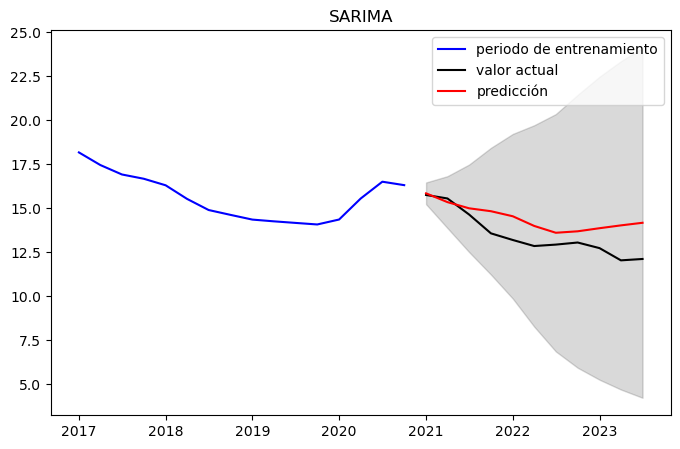

In [54]:
mod8=sm.tsa.statespace.SARIMAX(train_ara,order=(1,1,1), seasonal_order=(2,0,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(mod6.summary())
pred6=mod6.get_prediction('2021-01-01','2023-07-01')

print("                                           ")

#Hallamos el error medio:
mape(pred6.predicted_mean, test_esp)

# Dibujamos la predicción:
pred_ci6 = pred6.conf_int()

# Creando las series para su representación gráfica
pred6 = pd.Series(pred6.predicted_mean, index=test_esp.index)
lower_ci6 = pd.Series(pred_ci6["lower esp_des"], index=test_esp.index)
upper_ci6 = pd.Series(pred_ci6["upper esp_des"], index=test_esp.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
#Para que se pueda observar mejor en el informe
ax.plot(train_esp.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_esp, label="valor actual", color="black")
ax.plot(pred6, label="predicción", color='r')
ax.fill_between(lower_ci6.index,
                 lower_ci6,
                 upper_ci6,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

### 2.2.4. Importamos variables exógenas

In [55]:
#Importamos variables 
afil=pd.read_excel(file+"/Exog tp/afil.xlsx")
afil.set_index("fecha", inplace=True)
afil=afil["ara_des"]

par=pd.read_excel(file+"/Exog tp/par.xlsx")
par.set_index("fecha", inplace=True)
par=par["ara_des"].loc["2012-01":"2023-07"]

ta=pd.read_excel(file+"/Exog tp/ta.xlsx")
ta.set_index("fecha", inplace=True)
ta=ta["ara_des"].loc["2012-01":"2023-07"]

te=pd.read_excel(file+"/Exog tp/te.xlsx")
te.set_index("fecha", inplace=True)
te=te["ara_des"].loc["2012-01":"2023-07"]

tt=pd.read_excel(file+"/Exog tp/tt.xlsx")
tt.set_index("fecha", inplace=True)
tt=tt["ara_des"].loc["2012-01":"2023-07"]

In [56]:
#Analizamos la variable que este más correlacionada:
n_var=["afil", "par", "ta", "te", "tt"]
var=[afil, par, ta, te, tt]
exog_ar={}
corr_ara={}

for x,n in zip(var, n_var):
    exog_ar[n]=x
    corr_ara[n] = np.corrcoef(exog_ar[n], tp["ara_des"].loc["2012-01-01":"2023-07-01"])[0,1]
    print(f"Correlación entre {n}-tp en Aragón: {corr_ara[n]}")

Correlación entre afil-tp en Aragón: -0.9619027961031629
Correlación entre par-tp en Aragón: 0.998219537058179
Correlación entre ta-tp en Aragón: 0.4177841878207292
Correlación entre te-tp en Aragón: -0.985858406348934
Correlación entre tt-tp en Aragón: 0.10294668952352962


In [57]:
par=pd.read_excel(file+"/Exog tp/par.xlsx")
par.set_index("fecha", inplace=True)
par=par["ara_des"].loc["2011-01":"2023-07"]
exog_ar=(par/par.shift(4)-1)*100
exog_ar=exog_es.dropna()
exog_ar.columns=["ara_des"]

### 2.2.5. SARIMAX

D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                                ara_des   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                 -21.190
Date:                                Fri, 29 Dec 2023   AIC                             56.381
Time:                                        18:27:38   BIC                             64.913
Sample:                                    01-01-2012   HQIC                            58.747
                                         - 10-01-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1847      0.175     -1.057      0.290      -0.527       0.158
esp

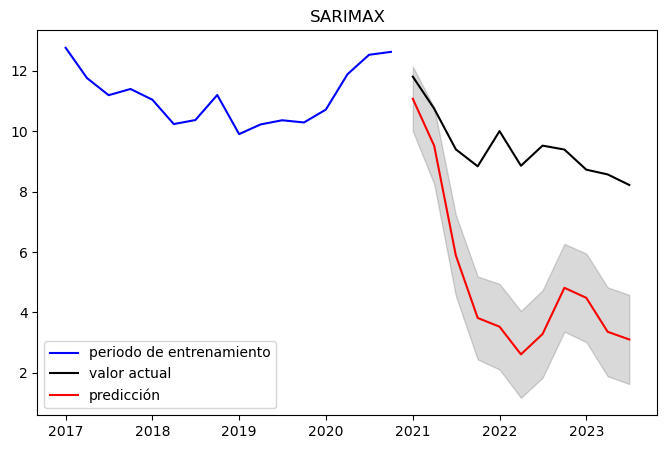

In [58]:
#Definimos trainis y test para varaible exógena:
exog_ar_train=exog_es.loc[:"2020-10"]
exog_ar_test=exog_es.loc["2021-01":"2023-07"]

#Estimamos y predecimos el modelo
modx4=sm.tsa.statespace.SARIMAX(train_ara.loc["2012-01":],  exog=exog_ar_train, order=(1,1,1),seasonal_order=(0,0,2,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(modx4.summary())
predx4 = modx4.get_prediction('2021-01', '2023-07', exog=exog_ar_test)

#Hallamos el error medio de la nueva predicción:
mape(predx4.predicted_mean, test_ara)

print("                                           ")

# Dibujamos la predicción:
pred_cix4 = predx4.conf_int()
pred_cix4.columns=["bajo", "alto"]

# Creando las series para su representación gráfica
bajox4=pd.Series(pred_cix4["bajo"])
altox4= pd.Series(pred_cix4["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(train_ara.loc["2017-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test_ara, label="valor actual", color="black")
ax.plot(predx4.predicted_mean, label="predicción", color='r')
ax.fill_between(bajox4.index,
                 bajox4,
                 altox4,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMAX")
plt.show()

### 2.2.6. Estimación final

#### Predecimos parados

In [59]:
#Predecimos valor de las importaciones para el cuarto trimestre:
g=pm.auto_arima(exog_ar, start_p=0, start_d=0, start_q=0,
                    max_p=3, max_d=1, max_q=3, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=3, max_D=1, max_Q=3,m=4, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=263.572, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=257.931, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,3)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=260.415, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(1,0,3)[4] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=259.873, Time=0.12 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(2,0,3)[4] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(3,0,0)[4] intercept   : AIC=261.859, Time=0.17 sec
 ARIMA(0,1,0)(3,0,1)[4] intercept   : AIC=263.845, Time=0.30 sec
 ARIMA(0,1,0)(3,0,2)[4] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec


In [60]:
#Predecimos valor:
h=sm.tsa.statespace.SARIMAX(exog_ar,order=(0,1,1),seasonal_order=(2,0,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

predh=h.get_prediction("2023-10-01")

In [61]:
# Obtener las predicciones como un DataFrame con índice
h = predf.predicted_mean.to_frame(name='ara_pred')
exog_ar = pd.concat([h, exog_ar], axis=1)

# Asegurar que el índice sea de tipo PeriodIndex
exog_ar.index = pd.PeriodIndex(exog_ar.index, freq='Q')

# Convertir el índice a formato "YYYY-MM-DD"
exog_ar.index = exog_ar.index.to_timestamp()

# Rellenar NaN con 0
exog_ar.fillna(0, inplace=True)

# Asegurarse de que 'esp_des' y 'esp_pred' sean del mismo tipo
exog_ar['ara_des'] = exog_ar['ara_des'].astype(float)
exog_ar['ara_pred'] = exog_ar['ara_pred'].astype(float)

# Unir valores
exog_ar["ara"] = exog_ar["ara_des"] + exog_ar["ara_pred"]

# Eliminar columnas innecesarias
drop = ['ara_pred', 'ara_des']
exog_ar.drop(drop, axis=1, inplace=True)

# Mostrar el DataFrame resultante
print(exog_ar)

                  ara
2012-01-01  16.307445
2012-04-01  18.424467
2012-07-01  15.765082
2012-10-01  13.623371
2013-01-01  10.453015
2013-04-01   5.545503
2013-07-01   2.093669
2013-10-01  -1.434778
2014-01-01  -5.606415
2014-04-01  -6.988083
2014-07-01  -8.553721
2014-10-01  -8.774094
2015-01-01  -7.638853
2015-04-01  -8.419801
2015-07-01 -11.242130
2015-10-01 -12.351708
2016-01-01 -12.431343
2016-04-01 -11.080881
2016-07-01  -9.867769
2016-10-01 -10.439248
2017-01-01 -12.058894
2017-04-01 -14.285072
2017-07-01 -13.579390
2017-10-01 -11.489733
2018-01-01 -10.392576
2018-04-01 -10.609279
2018-07-01 -11.578035
2018-10-01 -12.042549
2019-01-01 -11.860367
2019-04-01  -7.115240
2019-07-01  -3.670036
2019-10-01  -3.418565
2020-01-01  -0.190514
2020-04-01   4.541835
2020-07-01  13.728177
2020-10-01  15.388425
2021-01-01  10.679356
2021-04-01   5.520590
2021-07-01  -8.173859
2021-10-01 -15.520634
2022-01-01 -14.767840
2022-04-01 -16.960834
2022-07-01 -11.553495
2022-10-01  -2.532167
2023-01-01

#### Predecimos TP para Aragón

D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                                ara_des   No. Observations:                   47
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                 -30.318
Date:                                Fri, 29 Dec 2023   AIC                             74.637
Time:                                        18:28:23   BIC                             85.721
Sample:                                    01-01-2012   HQIC                            78.505
                                         - 07-01-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0128      0.057     -0.223      0.823      -0.125       0.100
ara

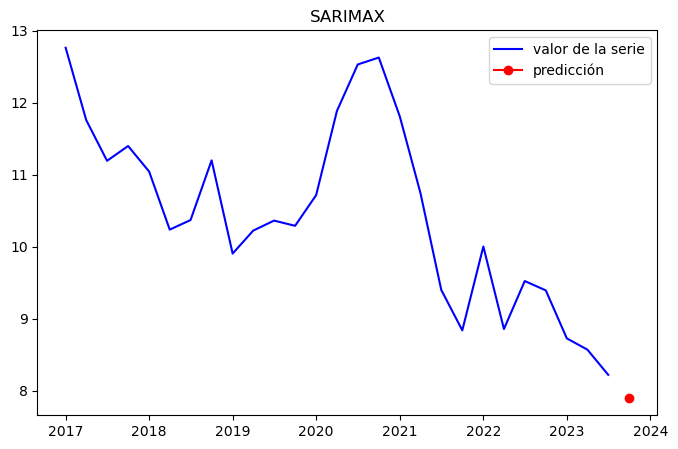

In [62]:
#Estimamos y predecimos el modelo
modxf4=sm.tsa.statespace.SARIMAX(tp["ara_des"].loc['2012-01-01':],  exog=exog_ar.loc[:"2023-07-01"], order=(1,1,1),seasonal_order=(0,0,2,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(modxf4.summary())
predxf4 = modxf4.get_prediction('2023-10', exog=exog_ar.loc["2023-10-01"])

print("                                           ")

# Creando las series para su representación gráfica
bajox4=pd.Series(pred_cix4["bajo"])
altox4= pd.Series(pred_cix4["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(tp["ara_des"].loc["2017-01-01":], label="valor de la serie", color="blue")
ax.plot(predxf4.predicted_mean, label="predicción", marker='o', color='r')
ax.legend()
ax.set_title("SARIMAX")
plt.show()

In [63]:
# Obtener las predicciones como un DataFrame
tp_ara=tp["ara_des"].loc["2017-01-01":]

tpf_ara = predxf4.predicted_mean.to_frame(name='f')

# Mostrar el DataFrame resultante
print("El valor de la tasa de paro para Aragón en el cuarto trimestre de 2023 es: ", tpf_ara["f"])

El valor de la tasa de paro para Aragón en el cuarto trimestre de 2023 es:  2023-10-01    7.899709
Freq: QS-OCT, Name: f, dtype: float64


# 3. Representación

In [116]:
#Tasas anualizadas:
pib_a["esp"]=(sum(p_esp.loc["2023-01-01":"2023-07-01"])+pf_esp["tv"])/4
pib_a["ara"]=(sum(p_ara.loc["2023-01-01":"2023-07-01"])+pf_ara["tv"])/4

tp_esp_a=(sum(tp_esp.loc["2023-01-01":"2023-07-01"])+tpf_esp)/4
tp_ara_a=(sum(tp_ara.loc["2023-01-01":"2023-07-01"])+tpf_ara)/4

print(pib_a, tp_esp_a, tp_ara_a)

2023-10-01 00:00:00                                             1.921337
esp                    2023-10-01    1.921337
Freq: QS-OCT, Name: tv,...
ara                    2023-10-01    1.93625
Freq: QS-OCT, Name: tv, ...
Name: tv, dtype: object                     f
2023-10-01  12.266287                   f
2023-10-01  8.35275


In [ ]:
#Valores de las predicciones:
n1=-0.28
n2= 1.14
n3= 12.2
n4= 7.9

C:\Users\jjime\AppData\Local\Temp\ipykernel_12620\3179613989.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1=plt.subplot2grid(gridsize,(0,0),colspan=100,rowspan=5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


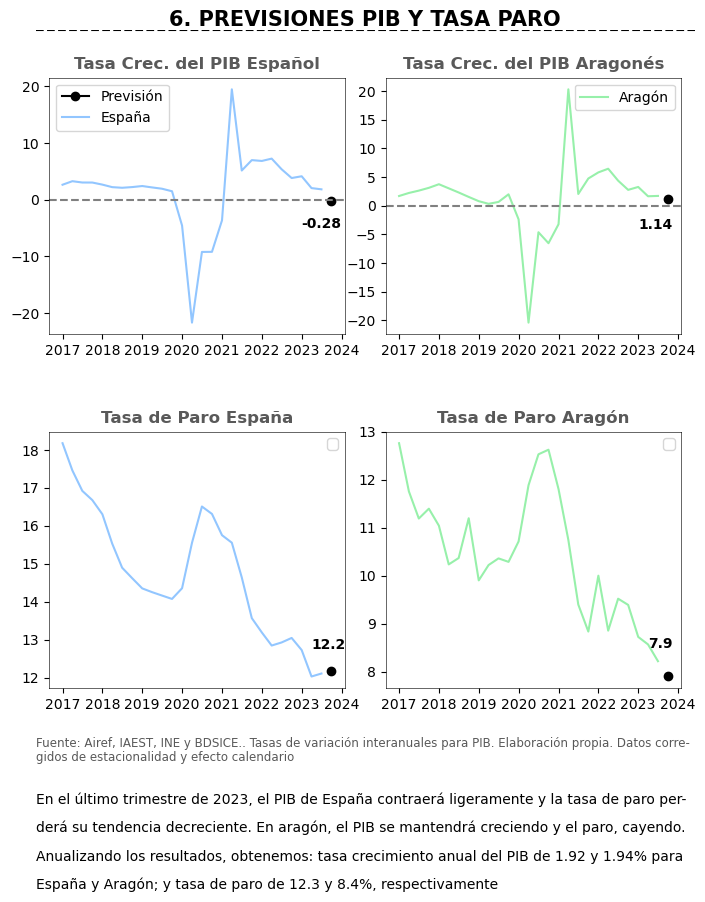

In [125]:
#Creamos primera página de mercado de trabajo:
gridsize=(100,100)
fig_size=(8.5,12.4)

fig,ax=plt.subplots(figsize=fig_size,dpi=100)

es= "#92C6FF"
ar="#97F0AA"

#Titulo:
ax1=plt.subplot2grid(gridsize,(0,0),colspan=100,rowspan=5)
text = "6. PREVISIONES PIB Y TASA PARO"
ax1.set_title(text, weight="bold", size=15, va="center")
ax1.axhline(1,0, color='black', linestyle='--')
ax1.axis("Off")

#PIB españa:
ax2=plt.subplot2grid(gridsize,(5,2), colspan=45, rowspan=27)
ax2.plot(pf_esp["tv"], marker='o', color="black", label="Previsión")
ax2.annotate(n1, xy=(['2023-01-01'], -5), weight="bold")
ax2.plot(p_esp, color=es, label="España")
ax2.axhline(0, color='grey', linestyle='--')
ax2.set_title("Tasa Crec. del PIB Español", weight="bold", alpha=0.65)

for axis in ['top', 'bottom', 'left', 'right']:
    ax2.spines[axis].set_linewidth(0.65)  
    ax2.spines[axis].set_alpha(0.65)
    
ax2.legend()

#PIB Aragón:
ax3=plt.subplot2grid(gridsize,(5,53), colspan=45, rowspan=27)
ax3.plot(pf_ara["tv"], marker='o', color="black")
ax3.plot(p_ara, color=ar, label="Aragón")
ax3.annotate(n2, xy=(['2023-01-01'], -4), weight="bold")
ax3.axhline(0, color='grey', linestyle='--')
ax3.set_title("Tasa Crec. del PIB Aragonés", weight="bold", alpha=0.65)

for axis in ['top', 'bottom', 'left', 'right']:
    ax3.spines[axis].set_linewidth(0.65)  
    ax3.spines[axis].set_alpha(0.65)
    
ax3.legend()

#Tasa de Paro España
ax4=plt.subplot2grid(gridsize,(42,2), colspan=45, rowspan=27)
ax4.plot(tpf_esp, marker='o', color="black")
ax4.annotate(n3, xy=(['2023-04-01'], 12.75), weight="bold")
ax4.plot(tp_esp, color=es)
ax4.set_title("Tasa de Paro España", weight="bold", alpha=0.65)


for axis in ['top', 'bottom', 'left', 'right']:
    ax4.spines[axis].set_linewidth(0.65)  
    ax4.spines[axis].set_alpha(0.65)
    
ax4.legend()
    
#Tasa de Paro Aragón
ax5=plt.subplot2grid(gridsize,(42,53), colspan=45, rowspan=27)
ax5.plot(tpf_ara, marker='o', color="black")
ax5.annotate(n4, xy=(['2023-04-01'], 8.5), weight="bold")
ax5.plot(tp_ara, color=ar)
ax5.set_title("Tasa de Paro Aragón", weight="bold", alpha=0.65)


for axis in ['top', 'bottom', 'left', 'right']:
    ax5.spines[axis].set_linewidth(0.65)  
    ax5.spines[axis].set_alpha(0.65)
    
ax5.legend()
    
#Comentario de los gráficos:
ax5=plt.subplot2grid(gridsize,(75,0), colspan=100, rowspan=15)
pie= "Fuente: Airef, IAEST, INE y BDSICE.. Tasas de variación interanuales para PIB. Elaboración propia. Datos corre-"
pie2="gidos de estacionalidad y efecto calendario"
com1="En el último trimestre de 2023, el PIB de España contraerá ligeramente y la tasa de paro per-"
com2="derá su tendencia decreciente. En aragón, el PIB se mantendrá creciendo y el paro, cayendo."
com3="Anualizando los resultados, obtenemos: tasa crecimiento anual del PIB de 1.92 y 1.94% para"
com4="España y Aragón; y tasa de paro de 12.3 y 8.4%, respectivamente"

ax5.text(0,1,pie, size=8.5, alpha=0.65)
ax5.text(0,0.9,pie2, size=8.5, alpha=0.65)
ax5.text(0,0.6,com1)
ax5.text(0,0.4,com2)
ax5.text(0,0.2,com3)
ax5.text(0,0,com4)
ax5.axis(False)

plt.savefig("Previsiones.pdf", format="pdf")
plt.show()